# Reproject the ESA-CCI land cover map for Europe

This notebook demonstrates the use of the xcube.core.resampling.resample_in_space function to reproject the ESA-CCI Land Cover Map of Europe for the year 2022. The entire process is performed lazily and thus can be easily scaled up. 

In [1]:
from xcube.core.store import new_data_store
from xcube.core.resampling.reproject import reproject_dataset
from xcube.core.resampling import resample_in_space
from xcube.core.gridmapping import GridMapping
from datetime import datetime
import matplotlib.pyplot as plt
import pyproj
import numpy as np

We use the land cover map stored in the [DeepESDL](https://www.earthsystemdatalab.net/) public S3 bucket. 

In [2]:
%%time
store = new_data_store("s3", root="deep-esdl-public")
mlds_lc = store.open_data("LC-1x2025x2025-2.0.0.levels")
ds = mlds_lc.base_dataset
ds

CPU times: user 480 ms, sys: 75.1 ms, total: 555 ms
Wall time: 1.22 s


<xarray.Dataset> Size: 3TB
Dimensions:              (time: 31, lat: 64800, lon: 129600, bounds: 2)
Coordinates:
  * lat                  (lat) float64 518kB 90.0 90.0 89.99 ... -90.0 -90.0
  * lon                  (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time                 (time) datetime64[ns] 248B 1992-01-01 ... 2022-01-01
Dimensions without coordinates: bounds
Data variables:
    change_count         (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    crs                  int32 4B ...
    current_pixel_state  (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lat_bounds           (lat, bounds) float64 1MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    lccs_class           (time, lat, lon) uint8 260GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    lon_bounds           (lon, bounds) float64 2MB dask.array<chunksize=(2025, 2), meta=np.ndarray>
    observation_count    (time, lat, lon) uint16 521GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    processed_flag       (time, lat, lon) float32 1TB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
    time_bounds          (time, bounds) datetime64[ns] 496B dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

We select the year and the spatial extend. 

In [3]:
%%time
ds = ds.sel(time=slice(datetime(2020, 1, 1), datetime(2022, 1, 1)))
ds = ds[["lccs_class"]]
ds

CPU times: user 136 ms, sys: 23.9 ms, total: 160 ms
Wall time: 155 ms


<xarray.Dataset> Size: 25GB
Dimensions:     (time: 3, lat: 64800, lon: 129600)
Coordinates:
  * lat         (lat) float64 518kB 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * lon         (lon) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time        (time) datetime64[ns] 24B 2020-01-01 2021-01-01 2022-01-01
Data variables:
    lccs_class  (time, lat, lon) uint8 25GB dask.array<chunksize=(1, 2025, 2025), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

We first need to generate a grid mapping in the desired CRS, which will be subseqeuntly used for the reprojection in the following cell. 

In [4]:
%%time
bbox = [8, 49, 13, 54]
target_crs = "EPSG:3035"
t = pyproj.Transformer.from_crs("EPSG:4326", target_crs, always_xy=True)
target_bbox = t.transform_bounds(*bbox)
spatial_res = 300
x_size = int((target_bbox[2] - target_bbox[0]) / spatial_res) + 1
y_size = int(abs(target_bbox[3] - target_bbox[1]) / spatial_res) + 1
target_gm = GridMapping.regular(
    size=(x_size, y_size),
    xy_min=(target_bbox[0] - spatial_res / 2, target_bbox[1] - spatial_res / 2),
    xy_res=spatial_res,
    crs=target_crs,
    tile_size=1000,
)

CPU times: user 79 ms, sys: 7.12 ms, total: 86.1 ms
Wall time: 83.7 ms


## New reprojection method 

In [5]:
%%time
ds_reproject = reproject_dataset(ds, target_gm=target_gm)
ds_reproject

CPU times: user 675 ms, sys: 11.5 ms, total: 687 ms
Wall time: 683 ms


<xarray.Dataset> Size: 7MB
Dimensions:      (time: 3, x: 1220, y: 1868)
Coordinates:
  * time         (time) datetime64[ns] 24B 2020-01-01 2021-01-01 2022-01-01
  * x            (x) float64 10kB 4.175e+06 4.175e+06 ... 4.54e+06 4.54e+06
  * y            (y) float64 15kB 3.436e+06 3.436e+06 ... 2.877e+06 2.876e+06
    spatial_ref  int64 8B 0
Data variables:
    lccs_class   (time, y, x) uint8 7MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

CPU times: user 1.98 s, sys: 342 ms, total: 2.32 s
Wall time: 1.59 s


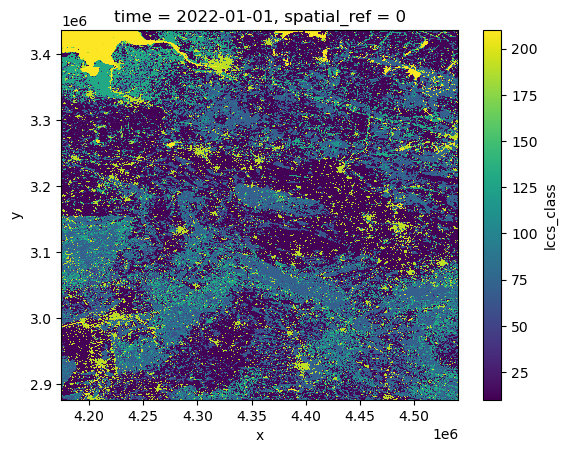

In [6]:
%%time
ds_reproject.lccs_class.isel(time=-1).plot()

## Old reprojection method via rectify_dataset

In [7]:
%%time
ds_resampling = ds.sel(lon=slice(-5, 25), lat=slice(60, 40))
ds_resampling = resample_in_space(ds_resampling, target_gm=target_gm)
ds_resampling

CPU times: user 2min 5s, sys: 9.56 s, total: 2min 14s
Wall time: 32.3 s


<xarray.Dataset> Size: 7MB
Dimensions:     (time: 3, y: 1868, x: 1220, bnds: 2)
Coordinates:
  * time        (time) datetime64[ns] 24B 2020-01-01 2021-01-01 2022-01-01
  * y           (y) float64 15kB 3.436e+06 3.436e+06 ... 2.877e+06 2.876e+06
  * x           (x) float64 10kB 4.175e+06 4.175e+06 ... 4.54e+06 4.54e+06
    x_bnds      (x, bnds) float64 20kB 4.174e+06 4.175e+06 ... 4.54e+06 4.54e+06
    y_bnds      (y, bnds) float64 30kB 3.437e+06 3.436e+06 ... 2.876e+06
Dimensions without coordinates: bnds
Data variables:
    lccs_class  (time, y, x) uint8 7MB dask.array<chunksize=(3, 1000, 1000), meta=np.ndarray>
    crs         int64 8B 0
Attributes: (12/38)
    Conventions:                CF-1.6
    TileSize:                   2025:2025
    cdm_data_type:              grid
    comment:                    
    contact:                    https://www.ecmwf.int/en/about/contact-us/get...
    creation_date:              20181130T095451Z
    ...                         ...
    time_coverage_end:          19921231
    time_coverage_resolution:   P1Y
    time_coverage_start:        19920101
    title:                      Land Cover Map of ESA CCI brokered by CDS
    tracking_id:                61b96fd7-42c3-4374-9de1-0dc3b0bcae2a
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y

/home/konstantin/micromamba/envs/xcube/lib/python3.13/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/home/konstantin/micromamba/envs/xcube/lib/python3.13/site-packages/numpy/_core/numeric.py:366: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


CPU times: user 22.1 s, sys: 2.1 s, total: 24.2 s
Wall time: 3.68 s


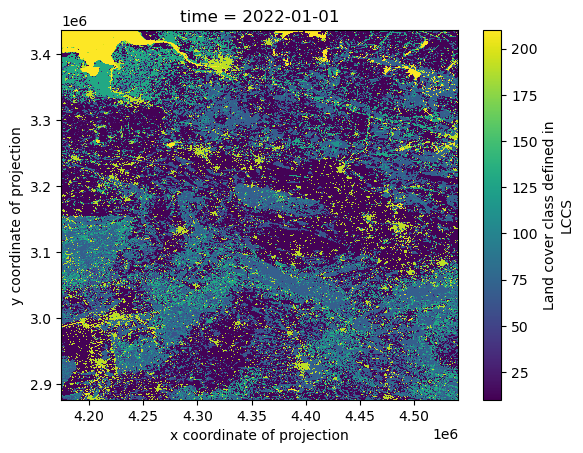

In [8]:
%%time
ds_resampling.lccs_class.isel(time=-1).plot()

## Difference

CPU times: user 22.6 s, sys: 2.06 s, total: 24.7 s
Wall time: 4.22 s


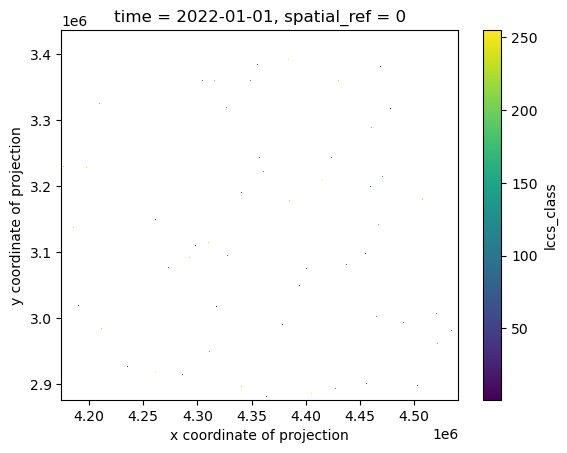

In [9]:
%%time 
diff = ds_resampling.lccs_class.isel(time=-1) - ds_reproject.lccs_class.isel(time=-1)
diff = diff.where(diff != 0, np.nan)
diff.plot()